In [1]:
%load_ext autoreload
%autoreload 2

In [18]:
# 导入必要的库
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
import yaml
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 导入自定义模块
from dataset import LungCancerDataset, load_config, create_dataloaders
from model_classification import ResNetClassifier, resnet18_classifier

print("库导入完成！")
print(f"PyTorch版本: {torch.__version__}")
print(f"CUDA可用: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA设备数量: {torch.cuda.device_count()}")
    print(f"当前CUDA设备: {torch.cuda.current_device()}")
    print(f"设备名称: {torch.cuda.get_device_name()}")

库导入完成！
PyTorch版本: 2.4.1
CUDA可用: True
CUDA设备数量: 1
当前CUDA设备: 0
设备名称: NVIDIA RTX A6000


In [19]:
# 加载配置文件
config = load_config("config.yaml")

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

# 设置随机种子
torch.manual_seed(config["experiment"]["seed"])
if torch.cuda.is_available():
    torch.cuda.manual_seed(config["experiment"]["seed"])
np.random.seed(config["experiment"]["seed"])

print(f"实验名称: {config['experiment']['name']}")
print(f"任务: {config['data']['task_name']}")
print(f"模态: {config['data']['modalities']}")

# 调试配置文件结构
print("配置文件的键:", list(config.keys()))
print("model配置:", config.get("model", "model键不存在"))

# 安全地获取model配置
model_config = config.get("model", {})
if model_config:
    print(f"模型架构: {model_config.get('architecture', '未设置')}")
    print(f"类别数: {model_config.get('num_classes', '未设置')}")
else:
    print("警告: 未找到model配置，将使用默认值")
    config["model"] = {
        "architecture": "resnet18",
        "num_classes": 2,
        "dropout_rate": 0.5,
        "pretrained_path": None
    }

成功加载配置文件: config.yaml
使用设备: cuda
实验名称: baseline_pet_2class
任务: ADC_vs_SCC
模态: ['PET']
配置文件的键: ['experiment', 'paths', 'data', 'model', 'training', 'dataloader']
model配置: {'architecture': 'resnet18', 'num_classes': 2, 'dropout_rate': 0.5, 'pretrained_path': None}
模型架构: resnet18
类别数: 2


In [22]:
# 创建数据加载器
print("创建数据加载器...")
train_loader, val_loader = create_dataloaders(config)

# 获取训练集和验证集的数据集对象，用于统计类别分布
train_dataset = train_loader.dataset
val_dataset = val_loader.dataset

# 输出每个类别的样本量
print("\n📊 数据集类别分布统计:")
print("=" * 50)

# 获取任务的标签映射信息
task_config = train_dataset.task_config
label_map = task_config["label_map"]
labels_to_include = task_config["labels_to_include"]

print(f"任务: {config['data']['task_name']}")
print(f"标签映射: {label_map}")

创建数据加载器...
初始化 train 数据集:
- 任务: ADC_vs_SCC
- Fold: fold_0
- 包含标签: ['ADC', 'SCC']
- 样本数量: 724
- 数据增强: 启用
初始化 val 数据集:
- 任务: ADC_vs_SCC
- Fold: fold_0
- 包含标签: ['ADC', 'SCC']
- 样本数量: 181
- 数据增强: 禁用

📊 数据集类别分布统计:
任务: ADC_vs_SCC
标签映射: {'ADC': 0, 'SCC': 1}


In [26]:
# 数据集检查工具 - 获取训练集标签分布
train_label_dist = train_dataset._get_label_distribution()
print(f"\n 训练集类别分布:")
total_train = sum(train_label_dist.values())
for pathology, count in train_label_dist.items():
    mapped_label = label_map.get(pathology, "未知")
    percentage = (count / total_train) * 100 if total_train > 0 else 0
    print(f"  {pathology} (标签 {mapped_label}): {count:4d} 样本 ({percentage:5.1f}%)")
print(f"  总计: {total_train} 样本")

# 获取验证集标签分布
val_label_dist = val_dataset._get_label_distribution()
print(f"\n 验证集类别分布:")
total_val = sum(val_label_dist.values())
for pathology, count in val_label_dist.items():
    mapped_label = label_map.get(pathology, "未知")
    percentage = (count / total_val) * 100 if total_val > 0 else 0
    print(f"  {pathology} (标签 {mapped_label}): {count:4d} 样本 ({percentage:5.1f}%)")
print(f"  总计: {total_val} 样本")

# 整体统计
print(f"\n整体统计:")
print(f"  训练集: {total_train} 样本")
print(f"  验证集: {total_val} 样本")
print(f"  总计: {total_train + total_val} 样本")

# 类别平衡性分析
print(f"\n类别平衡性分析:")
for pathology in labels_to_include:
    train_count = train_label_dist.get(pathology, 0)
    val_count = val_label_dist.get(pathology, 0)
    total_count = train_count + val_count
    train_ratio = (train_count / total_count) * 100 if total_count > 0 else 0
    val_ratio = (val_count / total_count) * 100 if total_count > 0 else 0
    mapped_label = label_map.get(pathology, "未知")
    print(f"  {pathology} (标签 {mapped_label}): 训练 {train_ratio:.1f}% | 验证 {val_ratio:.1f}%")



 训练集类别分布:
  SCC (标签 1):  265 样本 ( 36.6%)
  ADC (标签 0):  459 样本 ( 63.4%)
  总计: 724 样本

 验证集类别分布:
  SCC (标签 1):   66 样本 ( 36.5%)
  ADC (标签 0):  115 样本 ( 63.5%)
  总计: 181 样本

整体统计:
  训练集: 724 样本
  验证集: 181 样本
  总计: 905 样本

类别平衡性分析:
  ADC (标签 0): 训练 80.0% | 验证 20.0%
  SCC (标签 1): 训练 80.1% | 验证 19.9%


In [51]:
train_label_dist = train_dataset._get_label_distribution()
print(train_label_dist)

{'SCC': 265, 'ADC': 459}


🔍 3D Data Slice Visualization



📊 Train Dataset (Batch shape: torch.Size([8, 1, 128, 64, 96]))
  Sample 1 (Label: 0): Shape torch.Size([128, 64, 96]), Range[0.00, 0.95], Mean 0.03, Std 0.03


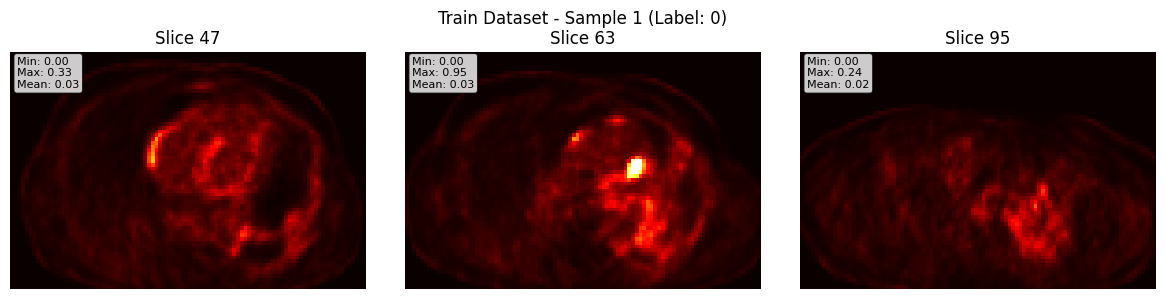

  Sample 2 (Label: 1): Shape torch.Size([128, 64, 96]), Range[0.00, 0.36], Mean 0.01, Std 0.02


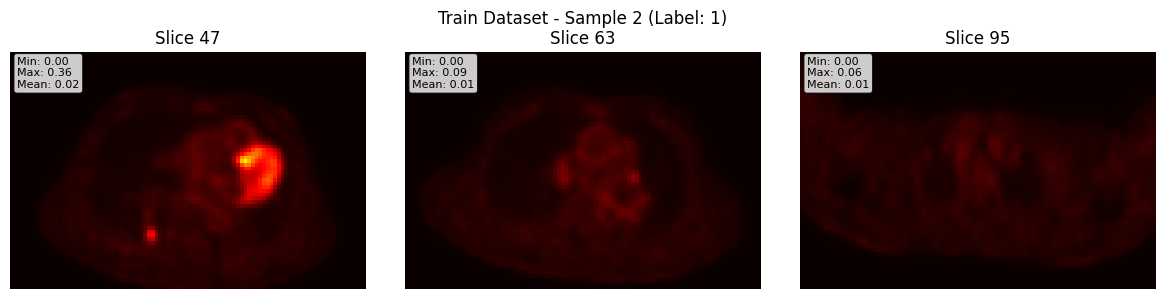


📊 Validation Dataset (Batch shape: torch.Size([8, 1, 128, 64, 96]))
  Sample 1 (Label: 1): Shape torch.Size([128, 64, 96]), Range[0.00, 0.38], Mean 0.01, Std 0.01


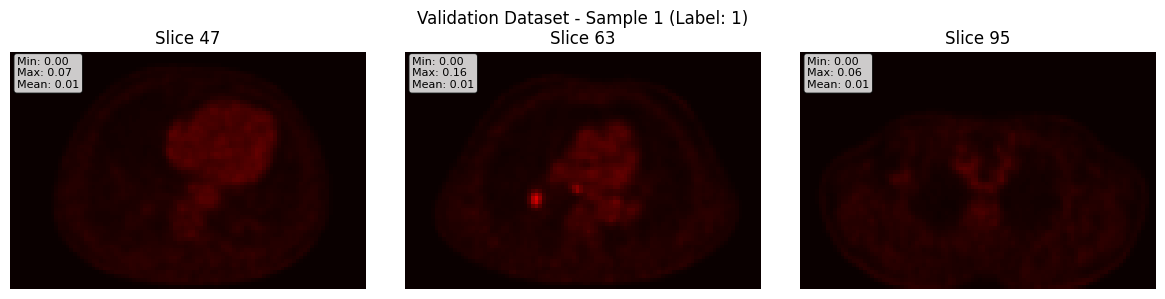

  Sample 2 (Label: 0): Shape torch.Size([128, 64, 96]), Range[0.00, 1.00], Mean 0.02, Std 0.03


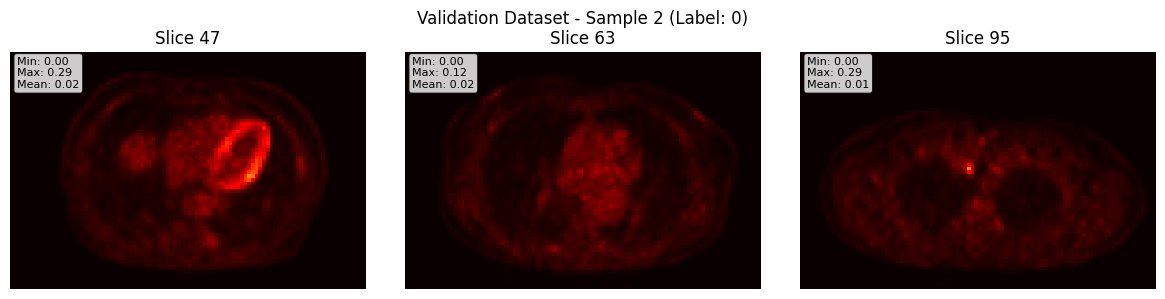


✅ Visualization Complete


In [40]:
# 3D Data Slice Visualization - Simplified Version
import matplotlib.pyplot as plt
import numpy as np
import torch

# Set matplotlib to handle Chinese characters properly (if needed) or use English
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']  # Use default font
plt.rcParams['axes.unicode_minus'] = False

# Configuration parameters
slice_indices = [47, 63, 95]
num_samples = 2  # Extract 2 samples from each dataset

print("🔍 3D Data Slice Visualization")
print("=" * 40)

# Get data batches
train_batch = next(iter(train_loader))
val_batch = next(iter(val_loader))

datasets = [
    ("Train", train_batch),
    ("Validation", val_batch)
]

for dataset_name, (data_batch, label_batch) in datasets:
    print(f"\n📊 {dataset_name} Dataset (Batch shape: {data_batch.shape})")
    
    for sample_idx in range(min(num_samples, data_batch.shape[0])):
        # Get sample data and label
        sample_data = data_batch[sample_idx]  # Shape: [C, D, H, W]
        sample_label = label_batch[sample_idx].item()
        
        # Get the first channel's volume data [D, H, W]
        volume = sample_data[0] if len(sample_data.shape) == 4 else sample_data
        
        # Data statistics
        print(f"  Sample {sample_idx + 1} (Label: {sample_label}): "
              f"Shape {volume.shape}, Range[{volume.min():.2f}, {volume.max():.2f}], "
              f"Mean {volume.mean():.2f}, Std {volume.std():.2f}")
        
        # Check if slices are valid (slice from D dimension - first dimension in [D, H, W])
        depth_size = volume.shape[0]  # D dimension is the first one [D, H, W]
        valid_slices = [s for s in slice_indices if 0 <= s < depth_size]
        
        if len(valid_slices) == 0:
            print(f"    Warning: No valid slices for depth {depth_size}")
            continue
        
        # Visualization with normalized [0, 1] color scale
        fig, axes = plt.subplots(1, len(valid_slices), figsize=(12, 3))
        if len(valid_slices) == 1:
            axes = [axes]
        
        for i, slice_idx in enumerate(valid_slices):
            # Slice from D dimension: volume[slice_idx, :, :] gives [H, W]
            slice_data = volume[slice_idx, :, :]
            if isinstance(slice_data, torch.Tensor):
                slice_data = slice_data.cpu().numpy()
            
            # Use normalized [0, 1] color scale
            im = axes[i].imshow(slice_data, cmap='hot', vmin=0.0, vmax=0.5)
            axes[i].set_title(f'Slice {slice_idx}')
            axes[i].axis('off')
            
            # Add statistics information
            axes[i].text(0.02, 0.98, 
                        f'Min: {slice_data.min():.2f}\nMax: {slice_data.max():.2f}\nMean: {slice_data.mean():.2f}', 
                        transform=axes[i].transAxes, fontsize=8, 
                        verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        plt.suptitle(f'{dataset_name} Dataset - Sample {sample_idx + 1} (Label: {sample_label})', fontsize=12)
        plt.tight_layout()
        plt.show()

print("\n✅ Visualization Complete")

In [41]:
# 创建模型
print("创建模型...")
in_channels = len(config["data"]["modalities"])  # 根据模态数量确定输入通道数
num_classes = config["model"]["num_classes"]
architecture = config["model"]["architecture"]

# 根据配置选择模型架构
if architecture == "resnet18":
    model = resnet18_classifier(
        in_channels=in_channels,
        num_classes=num_classes,
        dropout_rate=config["model"]["dropout_rate"]
    )
elif architecture == "resnet10":
    from model_classification import resnet10_classifier
    model = resnet10_classifier(
        in_channels=in_channels,
        num_classes=num_classes,
        dropout_rate=config["model"]["dropout_rate"]
    )
elif architecture == "resnet34":
    from model_classification import resnet34_classifier
    model = resnet34_classifier(
        in_channels=in_channels,
        num_classes=num_classes,
        dropout_rate=config["model"]["dropout_rate"]
    )
else:
    raise ValueError(f"不支持的模型架构: {architecture}")

# 将模型移至设备
model = model.to(device)

# 打印模型信息
print(f"模型架构: {architecture}")
print(f"输入通道数: {in_channels}")
print(f"输出类别数: {num_classes}")

# 计算模型参数数量
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"总参数数: {total_params:,}")
print(f"可训练参数数: {trainable_params:,}")

创建模型...


模型架构: resnet18
输入通道数: 1
输出类别数: 2
总参数数: 33,161,026
可训练参数数: 33,161,026


In [64]:
# 定义损失函数和优化器
# 计算类别权重以处理类别不平衡

print('损失函数设置')
# 获取训练集标签分布
train_label_dist = train_dataset._get_label_distribution()
print(f" - 训练集标签分布: {train_label_dist}")
print(f" - 标签映射: {label_map}")

# 使用label_map将病理类型转换为类别索引对应的数量
num_classes = len(label_map)
train_label_counts = [0] * num_classes

for pathology, count in train_label_dist.items():
    class_idx = label_map[pathology]
    train_label_counts[class_idx] = count

print(f" - 按类别索引排序的样本数量: {train_label_counts}")

# 计算类别权重
total_samples = sum(train_label_counts)
class_weights = [total_samples / (num_classes * count) for count in train_label_counts]

# 转换为张量
class_weights_tensor = torch.FloatTensor(class_weights).to(device)

print(f" - 类别权重: {[f'{w:.3f}' for w in class_weights]}")
print(f" - 权重比例: {class_weights[1]/class_weights[0]:.3f}:1 (Class 1:Class 0)")

# 使用加权交叉熵损失
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
print(f" - 损失函数: 加权交叉熵 (权重: {[f'{w:.3f}' for w in class_weights]})")


print('优化器设置')
optimizer = optim.AdamW(
    model.parameters(),
    lr=config["training"]["learning_rate"],
    weight_decay=config["training"]["weight_decay"]
)
print(f' - weight decay={config["training"]["weight_decay"]}')


print('学习率调度器设置')
# 带warmup的余弦退火学习率调度器
num_epochs = config["training"]["num_epochs"]
warmup_epochs = 5  # warmup阶段的epoch数
total_steps = len(train_loader) * num_epochs
warmup_steps = len(train_loader) * warmup_epochs

# 使用CosineAnnealingWarmRestarts和线性warmup的组合
from torch.optim.lr_scheduler import CosineAnnealingLR, LinearLR, SequentialLR

# 创建warmup调度器 (线性增长)
warmup_scheduler = LinearLR(
    optimizer, 
    start_factor=0.1,  # 从10%的学习率开始
    end_factor=1.0,    # 增长到100%的学习率
    total_iters=warmup_epochs
)

# 创建余弦退火调度器
cosine_scheduler = CosineAnnealingLR(
    optimizer,
    T_max=num_epochs - warmup_epochs,  # 余弦退火的周期长度
    eta_min=config["training"]["learning_rate"] * 0.01  # 最小学习率为初始学习率的1%
)

# 组合调度器：先warmup，后余弦退火
scheduler = SequentialLR(
    optimizer,
    schedulers=[warmup_scheduler, cosine_scheduler],
    milestones=[warmup_epochs]
)

print(f"  - Warmup epochs: {warmup_epochs}")
print(f"  - 初始学习率: {config['training']['learning_rate']}")
print(f"  - 最小学习率: {config['training']['learning_rate'] * 0.01}")

损失函数设置
 - 训练集标签分布: {'SCC': 265, 'ADC': 459}
 - 标签映射: {'ADC': 0, 'SCC': 1}
 - 按类别索引排序的样本数量: [459, 265]
 - 类别权重: ['0.789', '1.366']
 - 权重比例: 1.732:1 (Class 1:Class 0)
 - 损失函数: 加权交叉熵 (权重: ['0.789', '1.366'])
优化器设置
 - weight decay=0.1
学习率调度器设置
  - Warmup epochs: 5
  - 初始学习率: 0.0001
  - 最小学习率: 1.0000000000000002e-06


In [65]:
# Define training function - only return loss and AUC
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_targets = []
    all_probs = []
    
    with tqdm(train_loader, desc="Training") as pbar:
        for batch_idx, (data, targets) in enumerate(pbar):
            data, targets = data.to(device), targets.to(device)
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, targets)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Statistics for AUC calculation - 添加 detach() 分离梯度
            running_loss += loss.item()
            probs = torch.softmax(outputs, dim=1)
            _, predicted = outputs.max(1)
            
            # Save predictions for AUC calculation - 使用 detach() 分离梯度
            all_preds.extend(predicted.detach().cpu().numpy())
            all_targets.extend(targets.detach().cpu().numpy())
            all_probs.extend(probs.detach().cpu().numpy())
            
            # Update progress bar
            pbar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}'
            })
    
    epoch_loss = running_loss / len(train_loader)
    
    # Calculate training AUC
    from sklearn.metrics import roc_auc_score
    all_probs = np.array(all_probs)
    all_targets = np.array(all_targets)
    
    if len(np.unique(all_targets)) == 2:
        # Binary classification - use probability of positive class
        y_scores = all_probs[:, 1]
        train_auc = roc_auc_score(all_targets, y_scores)
    else:
        # Multi-class classification - use macro average
        train_auc = roc_auc_score(all_targets, all_probs, multi_class='ovr', average='macro')
    
    return epoch_loss, train_auc

# Define validation function with ROC AUC calculation
def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_targets = []
    all_probs = []
    
    with torch.no_grad():
        with tqdm(val_loader, desc="Validation") as pbar:
            for batch_idx, (data, targets) in enumerate(pbar):
                data, targets = data.to(device), targets.to(device)
                
                outputs = model(data)
                loss = criterion(outputs, targets)
                
                # 获取预测概率和预测类别
                probs = torch.softmax(outputs, dim=1)
                _, predicted = outputs.max(1)
                
                running_loss += loss.item()
                
                # Save predictions and probabilities for detailed analysis
                # 在 torch.no_grad() 上下文中，不需要 detach()，但保持一致性
                all_preds.extend(predicted.cpu().numpy())
                all_targets.extend(targets.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
                
                pbar.set_postfix({
                    'Loss': f'{running_loss/(batch_idx+1):.4f}'
                })
    
    epoch_loss = running_loss / len(val_loader)
    
    # Calculate ROC AUC
    from sklearn.metrics import roc_auc_score
    all_probs = np.array(all_probs)
    all_targets = np.array(all_targets)
    
    if len(np.unique(all_targets)) == 2:
        # Binary classification - use probability of positive class
        y_scores = all_probs[:, 1]
        val_auc = roc_auc_score(all_targets, y_scores)
    else:
        # Multi-class classification - use macro average
        val_auc = roc_auc_score(all_targets, all_probs, multi_class='ovr', average='macro')
    
    return epoch_loss, val_auc, all_preds, all_targets, all_probs

print("Training and validation functions defined with AUC-only tracking and gradient detachment")

Training and validation functions defined with AUC-only tracking and gradient detachment


In [66]:
# 主训练循环 - 使用ROC AUC监控早停
num_epochs = config["training"]["num_epochs"]
patience = config["training"]["patience"]
save_interval = config["training"]["save_interval"]
output_dir = config["experiment"]["output_dir"]

# 创建输出目录
os.makedirs(output_dir, exist_ok=True)

# 记录训练历史 - 只记录AUC，不再记录accuracy
train_losses = []
train_aucs = []  # 训练AUC
val_losses = []
val_aucs = []   # 验证AUC
learning_rates = []

best_val_auc = 0.0  # 使用AUC作为最佳模型标准
patience_counter = 0

print(f"开始训练，共 {num_epochs} 个epoch")
print(f"输出目录: {output_dir}")
print(f"早停监控指标: ROC AUC (patience={patience})")
print("-" * 60)

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    
    # 记录当前学习率
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)
    
    # 训练 - 现在返回loss和AUC
    train_loss, train_auc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # 验证 - 返回loss, AUC和预测结果
    val_loss, val_auc, val_preds, val_targets, val_probs = validate_epoch(model, val_loader, criterion, device)
    
    # 更新学习率（明确传入epoch参数避免deprecation警告）
    old_lr = optimizer.param_groups[0]['lr']
    scheduler.step(epoch)  # 明确传入epoch参数
    new_lr = optimizer.param_groups[0]['lr']
    
    # 记录历史
    train_losses.append(train_loss)
    train_aucs.append(train_auc)
    val_losses.append(val_loss)
    val_aucs.append(val_auc)
    
    # 打印epoch结果 - 只显示AUC
    print(f"Training   - Loss: {train_loss:.4f}, AUC: {train_auc:.4f}")
    print(f"Validation - Loss: {val_loss:.4f}, AUC: {val_auc:.4f}")
    print(f"Learning Rate: {current_lr:.2e}", end="")
    if new_lr != old_lr:
        print(f" → {new_lr:.2e} (已调整)")
    else:
        print("")
    
    # 使用ROC AUC来判断是否保存最佳模型
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_auc': val_auc,
            'train_auc': train_auc,
            'config': config
        }, os.path.join(output_dir, 'best_model.pth'))
        print(f"🏆 Best Model！Validation AUC: {val_auc:.4f}, 训练AUC: {train_auc:.4f}")
    else:
        patience_counter += 1
        print(f"⏳ Early Stop Count: {patience_counter}/{patience}")
    
    # 定期保存检查点
    if (epoch + 1) % save_interval == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_auc': val_auc,
            'train_auc': train_auc,
            'config': config
        }, os.path.join(output_dir, f'checkpoint_epoch_{epoch+1}.pth'))
        print(f"💾 Save checkpoint: epoch_{epoch+1}")
    
    # 早停检查 - 基于ROC AUC
    if patience_counter >= patience:
        print(f"\n🛑 Early Stop！Continuous {patience} 个epoch ROC AUC didn't improve")
        print(f"Best Val AUC: {best_val_auc:.4f}")
        break

print("\n🎉 Training Completed！")
print(f"Best Val AUC: {best_val_auc:.4f}")

开始训练，共 50 个epoch
输出目录: training_results/baseline_pet_2class
早停监控指标: ROC AUC (patience=20)
------------------------------------------------------------

Epoch 1/50


Training:   0%|          | 0/90 [00:00<?, ?it/s]

Validation: 100%|██████████| 23/23 [00:03<00:00,  6.64it/s, Loss=0.8275]



Training   - Loss: 0.1201, AUC: 0.9910
Validation - Loss: 0.8275, AUC: 0.7582
Learning Rate: 1.00e-05 → 2.80e-05 (已调整)
🏆 Best Model！Validation AUC: 0.7582, 训练AUC: 0.9910

Epoch 2/50
🏆 Best Model！Validation AUC: 0.7582, 训练AUC: 0.9910

Epoch 2/50


Validation: 100%|██████████| 23/23 [00:03<00:00,  7.43it/s, Loss=0.8889]


Training   - Loss: 0.1458, AUC: 0.9889
Validation - Loss: 0.8889, AUC: 0.7311
Learning Rate: 2.80e-05 → 4.60e-05 (已调整)
⏳ Early Stop Count: 1/20

Epoch 3/50


Validation: 100%|██████████| 23/23 [00:03<00:00,  7.46it/s, Loss=0.9313]


Training   - Loss: 0.1584, AUC: 0.9845
Validation - Loss: 0.9313, AUC: 0.7324
Learning Rate: 4.60e-05 → 6.40e-05 (已调整)
⏳ Early Stop Count: 2/20

Epoch 4/50


Validation: 100%|██████████| 23/23 [00:03<00:00,  6.35it/s, Loss=0.9530]


Training   - Loss: 0.2326, AUC: 0.9651
Validation - Loss: 0.9530, AUC: 0.7152
Learning Rate: 6.40e-05 → 8.20e-05 (已调整)
⏳ Early Stop Count: 3/20

Epoch 5/50


Validation: 100%|██████████| 23/23 [00:03<00:00,  7.55it/s, Loss=1.2075]
/home/yaobo/miniconda3/envs/totalseg/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Validation: 100%|██████████| 23/23 [00:03<00:00,  7.55it/s, Loss=1.2075]
/home/yaobo/miniconda3/envs/totalseg/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the dep

Training   - Loss: 0.2323, AUC: 0.9652
Validation - Loss: 1.2075, AUC: 0.6797
Learning Rate: 8.20e-05 → 1.00e-04 (已调整)
⏳ Early Stop Count: 4/20

Epoch 6/50


Validation: 100%|██████████| 23/23 [00:03<00:00,  7.45it/s, Loss=0.8826]


Training   - Loss: 0.2716, AUC: 0.9535
Validation - Loss: 0.8826, AUC: 0.7192
Learning Rate: 1.00e-04 → 9.99e-05 (已调整)
⏳ Early Stop Count: 5/20

Epoch 7/50


Validation: 100%|██████████| 23/23 [00:03<00:00,  7.50it/s, Loss=0.8970]


Training   - Loss: 0.2519, AUC: 0.9596
Validation - Loss: 0.8970, AUC: 0.7071
Learning Rate: 9.99e-05 → 9.95e-05 (已调整)
⏳ Early Stop Count: 6/20

Epoch 8/50


Validation: 100%|██████████| 23/23 [00:03<00:00,  7.46it/s, Loss=0.8175]


Training   - Loss: 0.2495, AUC: 0.9603
Validation - Loss: 0.8175, AUC: 0.7104
Learning Rate: 9.95e-05 → 9.89e-05 (已调整)
⏳ Early Stop Count: 7/20

Epoch 9/50


Validation: 100%|██████████| 23/23 [00:03<00:00,  7.47it/s, Loss=1.0787]


Training   - Loss: 0.1559, AUC: 0.9859
Validation - Loss: 1.0787, AUC: 0.6748
Learning Rate: 9.89e-05 → 9.81e-05 (已调整)
⏳ Early Stop Count: 8/20

Epoch 10/50


Validation: 100%|██████████| 23/23 [00:03<00:00,  6.89it/s, Loss=0.9624]



Training   - Loss: 0.2161, AUC: 0.9721
Validation - Loss: 0.9624, AUC: 0.7021
Learning Rate: 9.81e-05 → 9.70e-05 (已调整)
⏳ Early Stop Count: 9/20
💾 Save checkpoint: epoch_10

Epoch 11/50
💾 Save checkpoint: epoch_10

Epoch 11/50


Validation: 100%|██████████| 23/23 [00:03<00:00,  6.22it/s, Loss=0.9211]


Training   - Loss: 0.1995, AUC: 0.9747
Validation - Loss: 0.9211, AUC: 0.7560
Learning Rate: 9.70e-05 → 9.57e-05 (已调整)
⏳ Early Stop Count: 10/20

Epoch 12/50


Validation: 100%|██████████| 23/23 [00:03<00:00,  7.52it/s, Loss=1.0967]


Training   - Loss: 0.1422, AUC: 0.9889
Validation - Loss: 1.0967, AUC: 0.7152
Learning Rate: 9.57e-05 → 9.42e-05 (已调整)
⏳ Early Stop Count: 11/20

Epoch 13/50


Validation: 100%|██████████| 23/23 [00:03<00:00,  7.53it/s, Loss=0.9922]



Training   - Loss: 0.1851, AUC: 0.9785
Validation - Loss: 0.9922, AUC: 0.7653
Learning Rate: 9.42e-05 → 9.25e-05 (已调整)
🏆 Best Model！Validation AUC: 0.7653, 训练AUC: 0.9785

Epoch 14/50
🏆 Best Model！Validation AUC: 0.7653, 训练AUC: 0.9785

Epoch 14/50


Validation: 100%|██████████| 23/23 [00:03<00:00,  7.44it/s, Loss=0.9913]


Training   - Loss: 0.1667, AUC: 0.9825
Validation - Loss: 0.9913, AUC: 0.7431
Learning Rate: 9.25e-05 → 9.05e-05 (已调整)
⏳ Early Stop Count: 1/20

Epoch 15/50


Validation: 100%|██████████| 23/23 [00:03<00:00,  7.44it/s, Loss=1.0528]


Training   - Loss: 0.1419, AUC: 0.9894
Validation - Loss: 1.0528, AUC: 0.7427
Learning Rate: 9.05e-05 → 8.84e-05 (已调整)
⏳ Early Stop Count: 2/20

Epoch 16/50


Validation: 100%|██████████| 23/23 [00:03<00:00,  7.45it/s, Loss=1.1098]


Training   - Loss: 0.1510, AUC: 0.9835
Validation - Loss: 1.1098, AUC: 0.7120
Learning Rate: 8.84e-05 → 8.61e-05 (已调整)
⏳ Early Stop Count: 3/20

Epoch 17/50


Validation: 100%|██████████| 23/23 [00:03<00:00,  7.45it/s, Loss=1.3844]


Training   - Loss: 0.1402, AUC: 0.9861
Validation - Loss: 1.3844, AUC: 0.7090
Learning Rate: 8.61e-05 → 8.36e-05 (已调整)
⏳ Early Stop Count: 4/20

Epoch 18/50


Validation: 100%|██████████| 23/23 [00:03<00:00,  7.45it/s, Loss=1.2346]


Training   - Loss: 0.1716, AUC: 0.9799
Validation - Loss: 1.2346, AUC: 0.6797
Learning Rate: 8.36e-05 → 8.10e-05 (已调整)
⏳ Early Stop Count: 5/20

Epoch 19/50


Validation: 100%|██████████| 23/23 [00:03<00:00,  7.45it/s, Loss=1.0779]


Training   - Loss: 0.1388, AUC: 0.9881
Validation - Loss: 1.0779, AUC: 0.7078
Learning Rate: 8.10e-05 → 7.82e-05 (已调整)
⏳ Early Stop Count: 6/20

Epoch 20/50


Validation: 100%|██████████| 23/23 [00:03<00:00,  7.44it/s, Loss=1.0049]



Training   - Loss: 0.1390, AUC: 0.9877
Validation - Loss: 1.0049, AUC: 0.7290
Learning Rate: 7.82e-05 → 7.53e-05 (已调整)
⏳ Early Stop Count: 7/20
💾 Save checkpoint: epoch_20

Epoch 21/50
💾 Save checkpoint: epoch_20

Epoch 21/50


Validation: 100%|██████████| 23/23 [00:03<00:00,  6.55it/s, Loss=1.3731]


Training   - Loss: 0.0984, AUC: 0.9938
Validation - Loss: 1.3731, AUC: 0.7050
Learning Rate: 7.53e-05 → 7.22e-05 (已调整)
⏳ Early Stop Count: 8/20

Epoch 22/50


Validation: 100%|██████████| 23/23 [00:03<00:00,  6.21it/s, Loss=1.1092]


Training   - Loss: 0.0904, AUC: 0.9950
Validation - Loss: 1.1092, AUC: 0.7397
Learning Rate: 7.22e-05 → 6.90e-05 (已调整)
⏳ Early Stop Count: 9/20

Epoch 23/50


Validation: 100%|██████████| 23/23 [00:03<00:00,  7.47it/s, Loss=0.9127]


Training   - Loss: 0.1068, AUC: 0.9938
Validation - Loss: 0.9127, AUC: 0.7635
Learning Rate: 6.90e-05 → 6.58e-05 (已调整)
⏳ Early Stop Count: 10/20

Epoch 24/50


Validation: 100%|██████████| 23/23 [00:03<00:00,  7.29it/s, Loss=1.0989]


Training   - Loss: 0.0888, AUC: 0.9942
Validation - Loss: 1.0989, AUC: 0.7584
Learning Rate: 6.58e-05 → 6.25e-05 (已调整)
⏳ Early Stop Count: 11/20

Epoch 25/50


Validation: 100%|██████████| 23/23 [00:03<00:00,  6.61it/s, Loss=0.9207]



Training   - Loss: 0.0858, AUC: 0.9941
Validation - Loss: 0.9207, AUC: 0.7730
Learning Rate: 6.25e-05 → 5.91e-05 (已调整)
🏆 Best Model！Validation AUC: 0.7730, 训练AUC: 0.9941

Epoch 26/50
🏆 Best Model！Validation AUC: 0.7730, 训练AUC: 0.9941

Epoch 26/50


Validation: 100%|██████████| 23/23 [00:03<00:00,  7.19it/s, Loss=1.5594]


Training   - Loss: 0.0804, AUC: 0.9964
Validation - Loss: 1.5594, AUC: 0.7219
Learning Rate: 5.91e-05 → 5.57e-05 (已调整)
⏳ Early Stop Count: 1/20

Epoch 27/50


Validation: 100%|██████████| 23/23 [00:03<00:00,  7.50it/s, Loss=1.0525]


Training   - Loss: 0.0747, AUC: 0.9971
Validation - Loss: 1.0525, AUC: 0.7522
Learning Rate: 5.57e-05 → 5.22e-05 (已调整)
⏳ Early Stop Count: 2/20

Epoch 28/50


Validation: 100%|██████████| 23/23 [00:03<00:00,  7.47it/s, Loss=1.0088]



Training   - Loss: 0.0948, AUC: 0.9920
Validation - Loss: 1.0088, AUC: 0.7773
Learning Rate: 5.22e-05 → 4.88e-05 (已调整)
🏆 Best Model！Validation AUC: 0.7773, 训练AUC: 0.9920

Epoch 29/50
🏆 Best Model！Validation AUC: 0.7773, 训练AUC: 0.9920

Epoch 29/50


Validation: 100%|██████████| 23/23 [00:03<00:00,  7.40it/s, Loss=1.0865]


Training   - Loss: 0.0622, AUC: 0.9979
Validation - Loss: 1.0865, AUC: 0.7593
Learning Rate: 4.88e-05 → 4.53e-05 (已调整)
⏳ Early Stop Count: 1/20

Epoch 30/50


Validation: 100%|██████████| 23/23 [00:03<00:00,  6.94it/s, Loss=1.1238]



Training   - Loss: 0.0612, AUC: 0.9972
Validation - Loss: 1.1238, AUC: 0.7419
Learning Rate: 4.53e-05 → 4.19e-05 (已调整)
⏳ Early Stop Count: 2/20
💾 Save checkpoint: epoch_30

Epoch 31/50
💾 Save checkpoint: epoch_30

Epoch 31/50


Validation: 100%|██████████| 23/23 [00:03<00:00,  7.00it/s, Loss=1.2340]


Training   - Loss: 0.0346, AUC: 0.9995
Validation - Loss: 1.2340, AUC: 0.7324
Learning Rate: 4.19e-05 → 3.85e-05 (已调整)
⏳ Early Stop Count: 3/20

Epoch 32/50


Validation: 100%|██████████| 23/23 [00:03<00:00,  7.46it/s, Loss=1.2852]


Training   - Loss: 0.0617, AUC: 0.9977
Validation - Loss: 1.2852, AUC: 0.7298
Learning Rate: 3.85e-05 → 3.52e-05 (已调整)
⏳ Early Stop Count: 4/20

Epoch 33/50


Validation: 100%|██████████| 23/23 [00:03<00:00,  7.39it/s, Loss=1.3728]


Training   - Loss: 0.0416, AUC: 0.9983
Validation - Loss: 1.3728, AUC: 0.7270
Learning Rate: 3.52e-05 → 3.20e-05 (已调整)
⏳ Early Stop Count: 5/20

Epoch 34/50


Validation: 100%|██████████| 23/23 [00:03<00:00,  6.47it/s, Loss=1.2037]


Training   - Loss: 0.0378, AUC: 0.9990
Validation - Loss: 1.2037, AUC: 0.7428
Learning Rate: 3.20e-05 → 2.88e-05 (已调整)
⏳ Early Stop Count: 6/20

Epoch 35/50


Validation: 100%|██████████| 23/23 [00:04<00:00,  5.65it/s, Loss=1.2783]


Training   - Loss: 0.0199, AUC: 0.9999
Validation - Loss: 1.2783, AUC: 0.7290
Learning Rate: 2.88e-05 → 2.58e-05 (已调整)
⏳ Early Stop Count: 7/20

Epoch 36/50


Validation: 100%|██████████| 23/23 [00:03<00:00,  6.33it/s, Loss=1.2499]


Training   - Loss: 0.0480, AUC: 0.9979
Validation - Loss: 1.2499, AUC: 0.7477
Learning Rate: 2.58e-05 → 2.28e-05 (已调整)
⏳ Early Stop Count: 8/20

Epoch 37/50


Validation: 100%|██████████| 23/23 [00:03<00:00,  6.95it/s, Loss=1.3055]


Training   - Loss: 0.0413, AUC: 0.9992
Validation - Loss: 1.3055, AUC: 0.7416
Learning Rate: 2.28e-05 → 2.00e-05 (已调整)
⏳ Early Stop Count: 9/20

Epoch 38/50


Validation: 100%|██████████| 23/23 [00:03<00:00,  7.45it/s, Loss=1.2181]


Training   - Loss: 0.0315, AUC: 0.9990
Validation - Loss: 1.2181, AUC: 0.7466
Learning Rate: 2.00e-05 → 1.74e-05 (已调整)
⏳ Early Stop Count: 10/20

Epoch 39/50


Validation: 100%|██████████| 23/23 [00:03<00:00,  7.44it/s, Loss=1.1066]


Training   - Loss: 0.0185, AUC: 0.9999
Validation - Loss: 1.1066, AUC: 0.7513
Learning Rate: 1.74e-05 → 1.49e-05 (已调整)
⏳ Early Stop Count: 11/20

Epoch 40/50


Validation: 100%|██████████| 23/23 [00:03<00:00,  7.45it/s, Loss=1.1268]



Training   - Loss: 0.0188, AUC: 0.9999
Validation - Loss: 1.1268, AUC: 0.7574
Learning Rate: 1.49e-05 → 1.26e-05 (已调整)
⏳ Early Stop Count: 12/20
💾 Save checkpoint: epoch_40

Epoch 41/50
💾 Save checkpoint: epoch_40

Epoch 41/50


Validation: 100%|██████████| 23/23 [00:03<00:00,  7.41it/s, Loss=1.1641]


Training   - Loss: 0.0333, AUC: 0.9992
Validation - Loss: 1.1641, AUC: 0.7540
Learning Rate: 1.26e-05 → 1.05e-05 (已调整)
⏳ Early Stop Count: 13/20

Epoch 42/50


Validation: 100%|██████████| 23/23 [00:03<00:00,  6.56it/s, Loss=1.1860]


Training   - Loss: 0.0204, AUC: 0.9995
Validation - Loss: 1.1860, AUC: 0.7636
Learning Rate: 1.05e-05 → 8.52e-06 (已调整)
⏳ Early Stop Count: 14/20

Epoch 43/50


Validation: 100%|██████████| 23/23 [00:03<00:00,  7.50it/s, Loss=1.1282]


Training   - Loss: 0.0169, AUC: 0.9998
Validation - Loss: 1.1282, AUC: 0.7626
Learning Rate: 8.52e-06 → 6.79e-06 (已调整)
⏳ Early Stop Count: 15/20

Epoch 44/50


Validation: 100%|██████████| 23/23 [00:03<00:00,  7.50it/s, Loss=1.1426]


Training   - Loss: 0.0122, AUC: 1.0000
Validation - Loss: 1.1426, AUC: 0.7601
Learning Rate: 6.79e-06 → 5.28e-06 (已调整)
⏳ Early Stop Count: 16/20

Epoch 45/50


Validation: 100%|██████████| 23/23 [00:03<00:00,  7.50it/s, Loss=1.2135]


Training   - Loss: 0.0106, AUC: 1.0000
Validation - Loss: 1.2135, AUC: 0.7598
Learning Rate: 5.28e-06 → 3.99e-06 (已调整)
⏳ Early Stop Count: 17/20

Epoch 46/50


Validation: 100%|██████████| 23/23 [00:03<00:00,  6.08it/s, Loss=1.1418]


Training   - Loss: 0.0222, AUC: 0.9998
Validation - Loss: 1.1418, AUC: 0.7585
Learning Rate: 3.99e-06 → 2.92e-06 (已调整)
⏳ Early Stop Count: 18/20

Epoch 47/50


Validation: 100%|██████████| 23/23 [00:03<00:00,  7.43it/s, Loss=1.1700]


Training   - Loss: 0.0152, AUC: 0.9999
Validation - Loss: 1.1700, AUC: 0.7576
Learning Rate: 2.92e-06 → 2.08e-06 (已调整)
⏳ Early Stop Count: 19/20

Epoch 48/50


Validation: 100%|██████████| 23/23 [00:03<00:00,  7.45it/s, Loss=1.1703]

Training   - Loss: 0.0310, AUC: 0.9993
Validation - Loss: 1.1703, AUC: 0.7569
Learning Rate: 2.08e-06 → 1.48e-06 (已调整)
⏳ Early Stop Count: 20/20

🛑 Early Stop！Continuous 20 个epoch ROC AUC didn't improve
Best Val AUC: 0.7773

🎉 Training Completed！
Best Val AUC: 0.7773


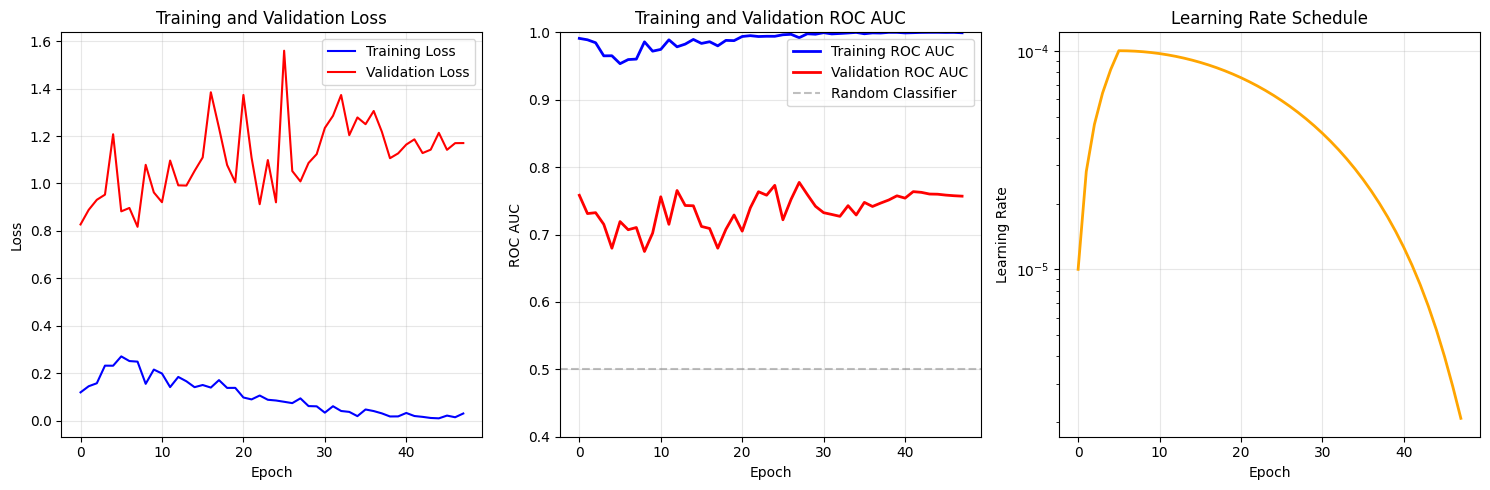

Training curves saved

📊 Training Summary:
Final Training AUC: 0.9993
Final Validation AUC: 0.7569
Best Validation AUC: 0.7773


In [67]:
# Plot training curves with ROC AUC only
plt.figure(figsize=(15, 5))

# Loss curve
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# ROC AUC curve
plt.subplot(1, 3, 2)
plt.plot(train_aucs, label='Training ROC AUC', color='blue', linewidth=2)
plt.plot(val_aucs, label='Validation ROC AUC', color='red', linewidth=2)
plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Random Classifier')
plt.xlabel('Epoch')
plt.ylabel('ROC AUC')
plt.title('Training and Validation ROC AUC')
plt.ylim([0.4, 1.0])
plt.legend()
plt.grid(True, alpha=0.3)

# Learning rate curve
plt.subplot(1, 3, 3)
plt.plot(learning_rates, 'orange', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.yscale('log')  # Use log scale for better visualization
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'training_curves.png'), dpi=300, bbox_inches='tight')
plt.show()

# Print training summary
print("Training curves saved")
print(f"\n📊 Training Summary:")
print(f"Final Training AUC: {train_aucs[-1]:.4f}")
print(f"Final Validation AUC: {val_aucs[-1]:.4f}")
print(f"Best Validation AUC: {best_val_auc:.4f}")

In [68]:
# Load best model for final evaluation
best_model_path = os.path.join(output_dir, 'best_model.pth')
if os.path.exists(best_model_path):
    print("Loading best model for evaluation...")
    checkpoint = torch.load(best_model_path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Best model from epoch {checkpoint['epoch']+1}")
    print(f"Best training AUC: {checkpoint.get('val_auc', 'N/A'):.4f}")
    # print(f"Best training Accuracy: {checkpoint.get('val_acc', 'N/A'):.2f}%")

# Final evaluation on validation set using the same method as training
print("\n" + "="*50)
print("FINAL EVALUATION")
print("="*50)

model.eval()
all_preds = []
all_targets = []
all_probs = []

with torch.no_grad():
    for data, targets in tqdm(val_loader, desc="Final Evaluation"):
        data, targets = data.to(device), targets.to(device)
        outputs = model(data)
        
        # 获取预测概率和预测类别（与训练时一致）
        probs = torch.softmax(outputs, dim=1)
        _, predicted = outputs.max(1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# 转换为numpy数组
all_probs = np.array(all_probs)
all_targets = np.array(all_targets)
all_preds = np.array(all_preds)

Loading best model for evaluation...


Best model from epoch 28
Best training AUC: 0.7773

FINAL EVALUATION


Final Evaluation: 100%|██████████| 23/23 [00:03<00:00,  6.83it/s]


In [69]:
# Import additional metrics for ROC curve
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Calculate detailed metrics
accuracy = accuracy_score(all_targets, all_preds)
print(f"\nFinal validation accuracy: {accuracy*100:.2f}%")

# Classification report
print("\nClassification Report:")
print(classification_report(all_targets, all_preds))

# Convert probabilities to numpy array for easier handling
all_probs = np.array(all_probs)
all_targets = np.array(all_targets)
all_preds = np.array(all_preds)

# Calculate AUC for binary classification
if len(np.unique(all_targets)) == 2:
    # For binary classification, use probability of positive class (class 1)
    y_scores = all_probs[:, 1]  # Probability of class 1
    auc_score = roc_auc_score(all_targets, y_scores)
    print(f"\nAUC Score: {auc_score:.4f}")
    
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(all_targets, y_scores)
    roc_auc = auc(fpr, tpr)
    print(f"ROC AUC: {roc_auc:.4f}")
else:
    print("Multi-class classification detected. Using macro-average AUC.")
    auc_score = roc_auc_score(all_targets, all_probs, multi_class='ovr', average='macro')
    print(f"Macro-average AUC: {auc_score:.4f}")


Final validation accuracy: 75.14%

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.79      0.80       115
           1       0.65      0.68      0.67        66

    accuracy                           0.75       181
   macro avg       0.73      0.74      0.73       181
weighted avg       0.75      0.75      0.75       181


AUC Score: 0.7773
ROC AUC: 0.7773


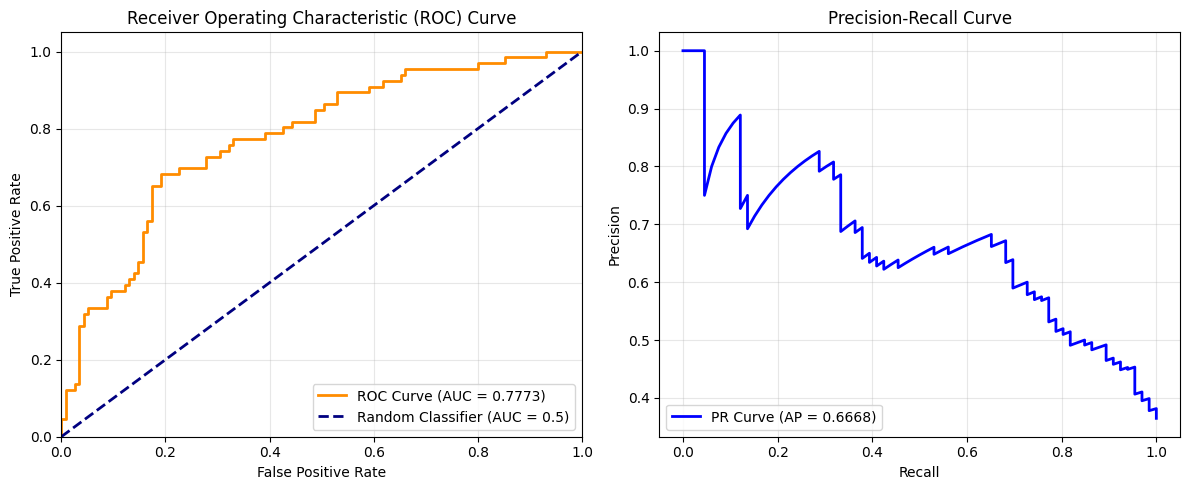

ROC curves saved


In [70]:
# Plot ROC Curve
plt.figure(figsize=(12, 5))

if len(np.unique(all_targets)) == 2:
    # Binary classification ROC curve
    plt.subplot(1, 2, 1)
    
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(all_targets, y_scores)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
             label='Random Classifier (AUC = 0.5)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    
    # Plot Precision-Recall curve as well
    from sklearn.metrics import precision_recall_curve, average_precision_score
    
    plt.subplot(1, 2, 2)
    precision, recall, _ = precision_recall_curve(all_targets, y_scores)
    avg_precision = average_precision_score(all_targets, y_scores)
    
    plt.plot(recall, precision, color='blue', lw=2,
             label=f'PR Curve (AP = {avg_precision:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.grid(True, alpha=0.3)
    
else:
    # Multi-class ROC curves
    from sklearn.preprocessing import label_binarize
    from itertools import cycle
    
    # Binarize the output
    y_test_bin = label_binarize(all_targets, classes=np.unique(all_targets))
    n_classes = y_test_bin.shape[1]
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot ROC curves for each class
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of class {i} (AUC = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC Curves')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'roc_curves.png'), dpi=300, bbox_inches='tight')
plt.show()

print("ROC curves saved")

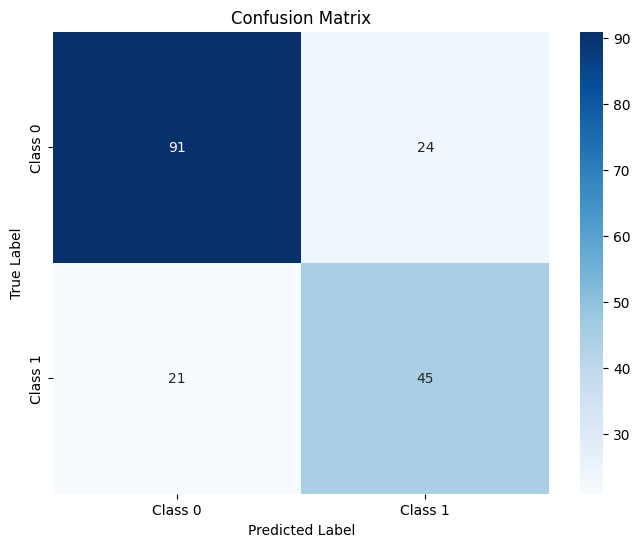

Training completed, all results saved to: training_results/baseline_pet_2class
Saved files include:
- best_model.pth: Best model weights (based on ROC AUC)
- training_curves.png: Training curves with AUC tracking
- confusion_matrix.png: Confusion matrix plot
- roc_curves.png: ROC and PR curves plot
- training_history.json: Complete training history with AUC data

🎯 Final Results Summary:
Best Validation ROC AUC: 0.7773
Final Validation ROC AUC: 0.7773
Final Validation Accuracy: 75.14%


In [71]:
# Plot confusion matrix
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0', 'Class 1'], 
            yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig(os.path.join(output_dir, 'confusion_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()

# Save comprehensive training history with AUC data only
training_history = {
    'train_losses': train_losses,
    'train_aucs': train_aucs,      # 训练集AUC历史
    'val_losses': val_losses,
    'val_aucs': val_aucs,          # 验证集AUC历史
    'learning_rates': learning_rates,
    'final_auc_score': float(auc_score),  # 最终AUC分数
    'best_val_auc': float(best_val_auc),  # 最佳验证AUC
    'early_stopping_metric': 'ROC_AUC',  # 记录早停使用的指标
    'early_stopping_patience': patience
}

import json
with open(os.path.join(output_dir, 'training_history.json'), 'w') as f:
    json.dump(training_history, f, indent=2)

print("Training completed, all results saved to:", output_dir)
print("Saved files include:")
print("- best_model.pth: Best model weights (based on ROC AUC)")
print("- training_curves.png: Training curves with AUC tracking")
print("- confusion_matrix.png: Confusion matrix plot")
print("- roc_curves.png: ROC and PR curves plot")
print("- training_history.json: Complete training history with AUC data")

print(f"\n🎯 Final Results Summary:")
print(f"{'='*40}")
print(f"Best Validation ROC AUC: {best_val_auc:.4f}")
print(f"Final Validation ROC AUC: {auc_score:.4f}")
print(f"Final Validation Accuracy: {accuracy*100:.2f}%")
print(f"{'='*40}")